In [2]:
!pip install utils scikit-learn matplotlib nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import sys
import pickle
import random


def file_to_wordset(filename):
    #''' Converts a file with a word per line to a Python set '''
    words = []
    with open(filename, 'r') as f:
        for line in f:
            words.append(line.strip())
    return set(words)


def write_status(i, total):
    #''' Writes status of a process to console '''
    sys.stdout.write('\r')
    sys.stdout.write('Processing %d/%d' % (i, total))
    sys.stdout.flush()


def save_results_to_csv(results, csv_file):
    #''' Save list of type [(tweet_id, positive)] to csv in Kaggle format '''
    with open(csv_file, 'w') as csv:
        csv.write('id,prediction\n')
        for tweet_id, pred in results:
            csv.write(tweet_id)
            csv.write(',')
            csv.write(str(pred))
            csv.write('\n')


def top_n_words(pkl_file_name, N, shift=0):
    """
    Returns a dictionary of form {word:rank} of top N words from a pickle
    file which has a nltk FreqDist object generated by stats.py

    Args:
        pkl_file_name (str): Name of pickle file
        N (int): The number of words to get
        shift: amount to shift the rank from 0.
    Returns:
        dict: Of form {word:rank}
    """
    with open(pkl_file_name, 'rb') as pkl_file:
        freq_dist = pickle.load(pkl_file)
    most_common = freq_dist.most_common(N)
    words = {p[0]: i + shift for i, p in enumerate(most_common)}
    return words


def top_n_bigrams(pkl_file_name, N, shift=0):
    """
    Returns a dictionary of form {bigram:rank} of top N bigrams from a pickle
    file which has a Counter object generated by stats.py

    Args:
        pkl_file_name (str): Name of pickle file
        N (int): The number of bigrams to get
        shift: amount to shift the rank from 0.
    Returns:
        dict: Of form {bigram:rank}
    """
    with open(pkl_file_name, 'rb') as pkl_file:
        freq_dist = pickle.load(pkl_file)
    most_common = freq_dist.most_common(N)
    bigrams = {p[0]: i for i, p in enumerate(most_common)}
    return bigrams


def split_data(tweets, validation_split=0.1):
    """Split the data into training and validation sets

    Args:
        tweets (list): list of tuples
        validation_split (float, optional): validation split %

    Returns:
        (list, list): training-set, validation-set
    """
    index = int((1 - validation_split) * len(tweets))
    random.shuffle(tweets)
    return tweets[:index], tweets[index:]


In [7]:
import utils
import random
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Performs classification using Naive Bayes.

FREQ_DIST_FILE = 'train-processed-freqdist.pkl'
BI_FREQ_DIST_FILE = 'train-processed-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE = 'train-processed.csv'
TEST_PROCESSED_FILE = 'test-processed.csv'
TRAIN = True
UNIGRAM_SIZE = 15000
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = True
if USE_BIGRAMS:
    BIGRAM_SIZE = 10000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'frequency'


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in range(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = lil_matrix((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def apply_tf_idf(X):
    transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)
    transformer.fit(X)
    return transformer


def process_tweets(csv_file, test_file=True):
    """Returns a list of tuples of type (tweet_id, feature_vector)
            or (tweet_id, sentiment, feature_vector)

    Args:
        csv_file (str): Name of processed csv file generated by preprocess.py
        test_file (bool, optional): If processing test file

    Returns:
        list: Of tuples
    """
    tweets = []
    print('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            write_status(i + 1, total)
    print('\n')
    return tweets


if __name__ == '__main__':
    np.random.seed(1337)
    unigrams = top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
    if USE_BIGRAMS:
        bigrams = top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
    if TRAIN:
        train_tweets, val_tweets = split_data(tweets)
    else:
        random.shuffle(tweets)
        train_tweets = tweets
    del tweets
    print('Extracting features & training batches')
    clf = MultinomialNB()
    batch_size = len(train_tweets)
    i = 1
    n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))
    for training_set_X, training_set_y in extract_features(train_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
        write_status(i, n_train_batches)
        i += 1
        if FEAT_TYPE == 'frequency':
            tfidf = apply_tf_idf(training_set_X)
            training_set_X = tfidf.transform(training_set_X)
        clf.partial_fit(training_set_X, training_set_y, classes=[0, 1])
    print('\n')
    print('Testing')
    if TRAIN:
        correct, total = 0, len(val_tweets)
        i = 1
        batch_size = len(val_tweets)
        n_val_batches = int(np.ceil(len(val_tweets) / float(batch_size)))
        for val_set_X, val_set_y in extract_features(val_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
            if FEAT_TYPE == 'frequency':
                val_set_X = tfidf.transform(val_set_X)
            prediction = clf.predict(val_set_X)
            correct += np.sum(prediction == val_set_y)
            write_status(i, n_val_batches)
            i += 1
        print ('\nCorrect: %d/%d = %.4f %%' % (correct, total, correct * 100. / total))
    else:
        del train_tweets
        test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
        n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
        predictions = np.array([])
        print('Predicting batches')
        i = 1
        for test_set_X, _ in extract_features(test_tweets, test_file=True, feat_type=FEAT_TYPE):
            if FEAT_TYPE == 'frequency':
                test_set_X = tfidf.transform(test_set_X)
            prediction = clf.predict(test_set_X)
            predictions = np.concatenate((predictions, prediction))
            write_status(i, n_test_batches)
            i += 1
        predictions = [(str(j), int(predictions[j]))
                       for j in range(len(test_tweets))]
        save_results_to_csv(predictions, 'naivebayes.csv')
        print('\nSaved to naivebayes.csv')


Generating feature vectors
Processing 16055/16055

Extracting features & training batches
Processing 1/1

Testing
Processing 1/1
Correct: 1501/1606 = 93.4620 %


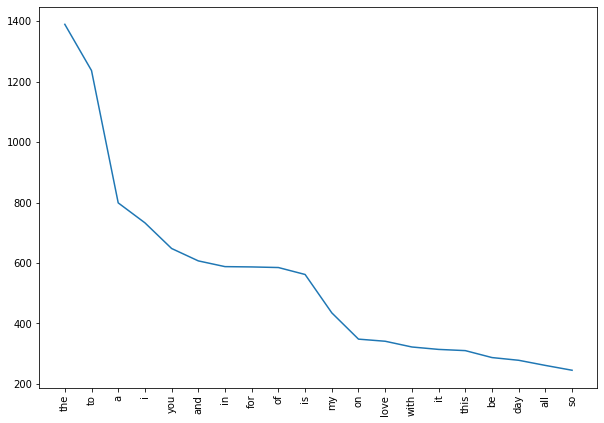

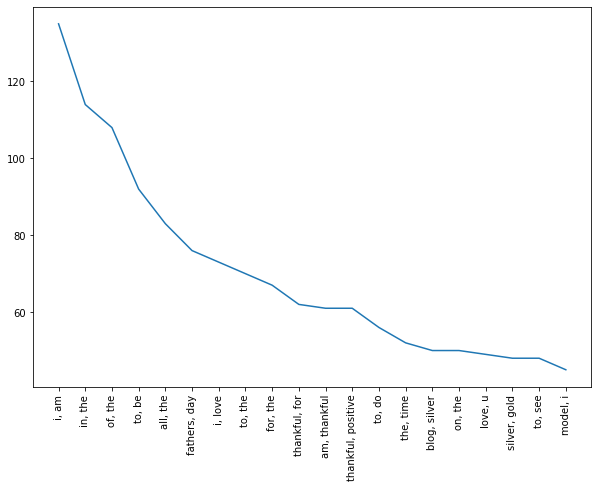

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import utils
import pickle
%matplotlib inline

FREQ_DIST_FILE = 'train-processed-freqdist.pkl'
BI_FREQ_DIST_FILE = 'train-processed-freqdist-bi.pkl'

with open(FREQ_DIST_FILE, 'rb') as pkl_file:
    freq_dist = pickle.load(pkl_file)
unigrams = freq_dist.most_common(20)


plt.figure(1, [10, 7])
x = np.array(range(0, 40, 2))
y = np.array([i[1] for i in unigrams])
my_xticks = [i[0] for i in unigrams]
plt.xticks(x, my_xticks, rotation=90)
plt.plot(x, y)
plt.show()

with open(BI_FREQ_DIST_FILE, 'rb') as pkl_file:
    freq_dist = pickle.load(pkl_file)
bigrams = freq_dist.most_common(20)

plt.figure(1, [10, 7])
x = np.array(range(0, 40, 2))
y = np.array([i[1] for i in bigrams])
my_xticks = [', '.join(i[0]) for i in bigrams]
plt.xticks(x, my_xticks, rotation=90)
plt.plot(x, y)
plt.show()
